# Time Series Analysis

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

from datetime import timedelta
import datetime
import calendar

import matplotlib.pyplot as plt

## Importing modeling libraries

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Data pre-processing

In [4]:
path = 'time_series_work_book.xlsx'
dataFrame = pd.read_excel(path)
dataFrame.rename(columns={'Unnamed: 0':'Month'}, inplace=True)

In [5]:
# converting hours to minuts
def convert_to_minutes(t):
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    minutes = seconds/60
    return minutes

for i in range(1,len(dataFrame.columns)):
    dataFrame.iloc[:,i] = dataFrame.iloc[:,i].apply(convert_to_minutes)

In [6]:
# converting object type to datatime in month column
Today = datetime.datetime(2020,1,1)
for i in range(30):
    months = i
    month = Today.month - 1 + months
    year = Today.year + month // 12
    month = month % 12 + 1
    day = min(Today.day, calendar.monthrange(year,month)[1])
    dataFrame.iloc[i,0] = datetime.date(year, month, day)    

dataFrame['Month'] = pd.to_datetime(dataFrame['Month'],format='%Y-%m-%d')
dataFrame.set_index(['Month'], inplace=True)
dataFrame.index = pd.DatetimeIndex(dataFrame.index.values, freq=dataFrame.index.inferred_freq)

In [7]:
print(dataFrame.shape)
dataFrame.head(2)

(30, 13)


,Average Admission Time ( Overall ),Average Admission Time ( Male Patients ),Average Admission Time ( Female Patients ),Average Admission Time ( Insurance Patients ),Average Admission Time ( Self-pay Patients ),Average Admission Time ( International Patients ),Average Admission Time ( Local Patients ),Average Admission Time ( Infant ),Average Admission Time ( Child ),Average Admission Time ( Teen ),Average Admission Time ( Junior Adult ),Average Admission Time ( Senior Adult ),Average Admission Time ( Senior Citizen )
2020-01-01,163.4,161.016667,165.800000,169.283333,141.383333,153.333333,164.050000,155.483333,150.266667,162.733333,162.833333,176.900000,158.8
2020-02-01,143.6,144.033333,143.166667,148.166667,123.916667,154.300000,142.883333,138.533333,125.650000,127.466667,144.133333,161.616667,137.4


In [8]:
def select_column(dataframe,columnIndex):
    return dataframe.iloc[:,columnIndex]

In [9]:
def time_series_plot(series):
    print('Time profile of %s'%series.name)
    plt.figure(figsize=(14,5))
    plt.plot(series,color='r')
    plt.show()

In [37]:
def test_stationary(window_size,series):
    print('Testing of stationality')
    
    #Rolling statistics:
    rolmean = series.rolling(window=window_size).mean()
    rolstd = series.rolling(window=window_size).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(14,5))
    plt.plot(series, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [11]:
def transformation(series):
    print('log transformation of dataset')
    series_logScale = np.log(series)
    return series_logScale

In [12]:
def moving_average(window_size, series_logScale):
    print('Moving Average Method')
    moving_avg = series_logScale.rolling(window=window_size).mean()
    
    #Ploting moving average
    plt.figure(figsize=(14,5))
    plt.plot(series_logScale, color='blue',label='Original')
    plt.plot(moving_avg, color='red', label='Moving average')
    plt.legend(loc='best')
    plt.title('Moving average')

In [13]:
def making_stationary_ts(window_size, series_logscale):
    print('Making time series stationary by moving average method')
    moving_avg = series_logscale.rolling(window=window_size).mean()
    dataframe_minus_moving_avg = series_logscale - moving_avg
    
    #Removing NaNs
    dataframe_minus_moving_avg.dropna(inplace=True)
    return dataframe_minus_moving_avg

In [14]:
def making_stationary_weighted(window_size, series_logScale):
    print('Making time series stationary by weighted mean method')
    
    exponantialDecayWeightedAverage = series_logScale.ewm(halflife=3).mean()
    series_logScale_minus_exponantialDecayWeightedAverage = series_logScale - exponantialDecayWeightedAverage
    
    #Removing NaNs
    series_logScale_minus_exponantialDecayWeightedAverage.dropna(inplace=True)
    return series_logScale_minus_exponantialDecayWeightedAverage

In [15]:
def lag_operator(series_logScale):
    print('lag operator')
    datasetLagdiffShifting = series_logScale - series_logScale.shift()
    datasetLagdiffShifting.dropna(inplace=True)
    return datasetLagdiffShifting

In [16]:
#Decompose
def decompose(series_logScale):
    print('Decomposition of time series into its components')
    decomposition = seasonal_decompose(series_logScale)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(14,14))
    plt.subplot(411)
    plt.plot(series_logScale, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

In [17]:
def acf_pacf(series_LagdiffShifting,nlags):
    print('Calculating ACF and PACF')
    lag_acf = acf(series_LagdiffShifting, nlags=nlags)
    lag_pacf = pacf(series_LagdiffShifting,nlags=nlags, method='ols')

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series_LagdiffShifting)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series_LagdiffShifting)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series_LagdiffShifting)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series_LagdiffShifting)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [18]:
#ARIMA model
def fit_model(series_logScale,series_LagdiffShifting,p,d,q):
    print('Fitting the model for given data')
    model = ARIMA(series_logScale,order=(p, d, q))  
    results_ARIMA = model.fit()
    
    plt.figure(figsize=(12,4))
    plt.plot(series_LagdiffShifting)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.title('RSS: %s'%sum(((results_ARIMA.fittedvalues-series_logScale).dropna())**2))

In [65]:
def predict(series_logScale,datapoints,p,d,q):
    print('Predicting and forecasting, values are in minutes')
    model = ARIMA(np.exp(series_logScale),order=(p, d, q))  
    result_ARIMA = model.fit()
    
    result_ARIMA.plot_predict(1,len(series_logScale)+datapoints)
    return pd.DataFrame(result_ARIMA.forecast(steps = datapoints))

## Analysis of time series

### 1. Time series profile

In [56]:
# Select column number
avgAdmissionTime = select_column(dataFrame,0)
avgAdmissionTime.name

'Average Admission Time ( Overall )'

Time profile of Average Admission Time ( Overall )


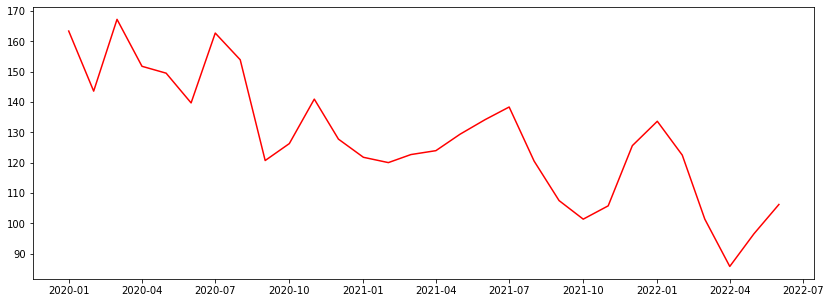

In [57]:
time_series_plot(avgAdmissionTime)

### 2. Testing stationarity of original data

Testing of stationality


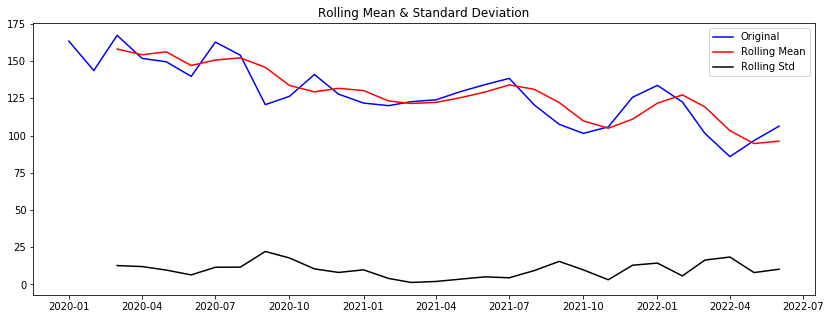

Results of Dickey-Fuller Test:
Test Statistic                 -1.935842
p-value                         0.315392
#Lags Used                      2.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


In [58]:
test_stationary(3,avgAdmissionTime)

###  3. Making sseries stationary

log transformation of dataset
Moving Average Method


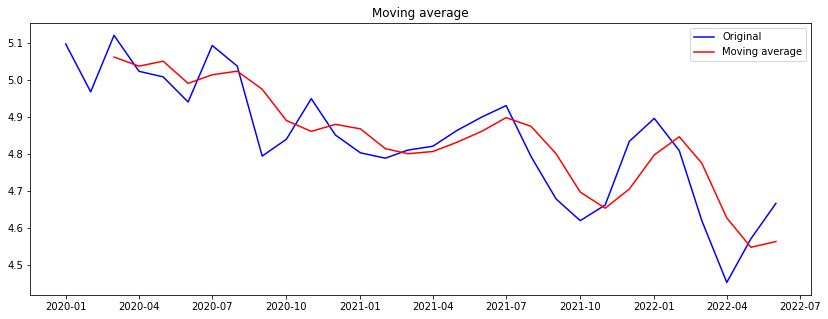

In [59]:
avgAdmissionTime_logScale = transformation(avgAdmissionTime)
moving_average(3,avgAdmissionTime_logScale)

Making time series stationary by moving average method
Testing of stationality


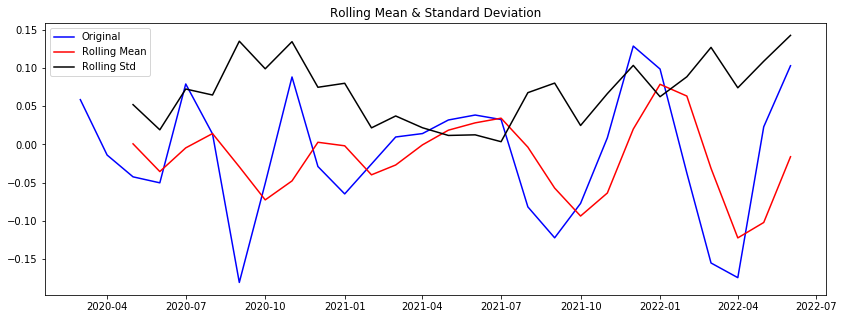

Results of Dickey-Fuller Test:
Test Statistic                 -3.843366
p-value                         0.002494
#Lags Used                      2.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [60]:
avgAdmissionTime_stationary = making_stationary_ts(3,avgAdmissionTime_logScale)
test_stationary(3,avgAdmissionTime_stationary)

lag operator
Testing of stationality


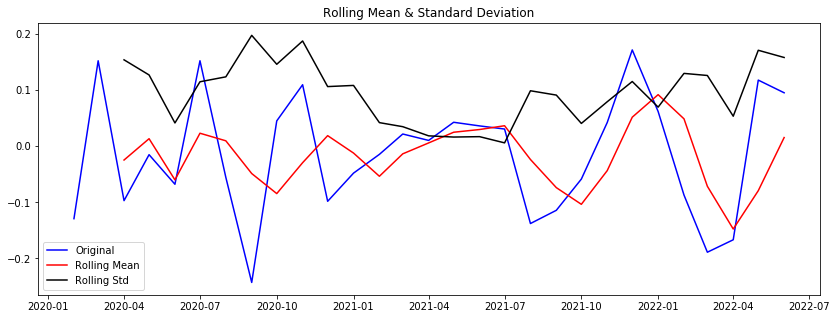

Results of Dickey-Fuller Test:
Test Statistic                 -3.979892
p-value                         0.001520
#Lags Used                      3.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [61]:
avgAdmissionTimeLagdiffShifting = lag_operator(avgAdmissionTime_logScale)    
test_stationary(3,avgAdmissionTimeLagdiffShifting)

In [ ]:
avgAdmissionTimeLagdiffShifting_2 = lag_operator(avgAdmissionTimeLagdiffShifting)    
test_stationary(3,avgAdmissionTimeLagdiffShifting_2)

Decomposition of time series into its components


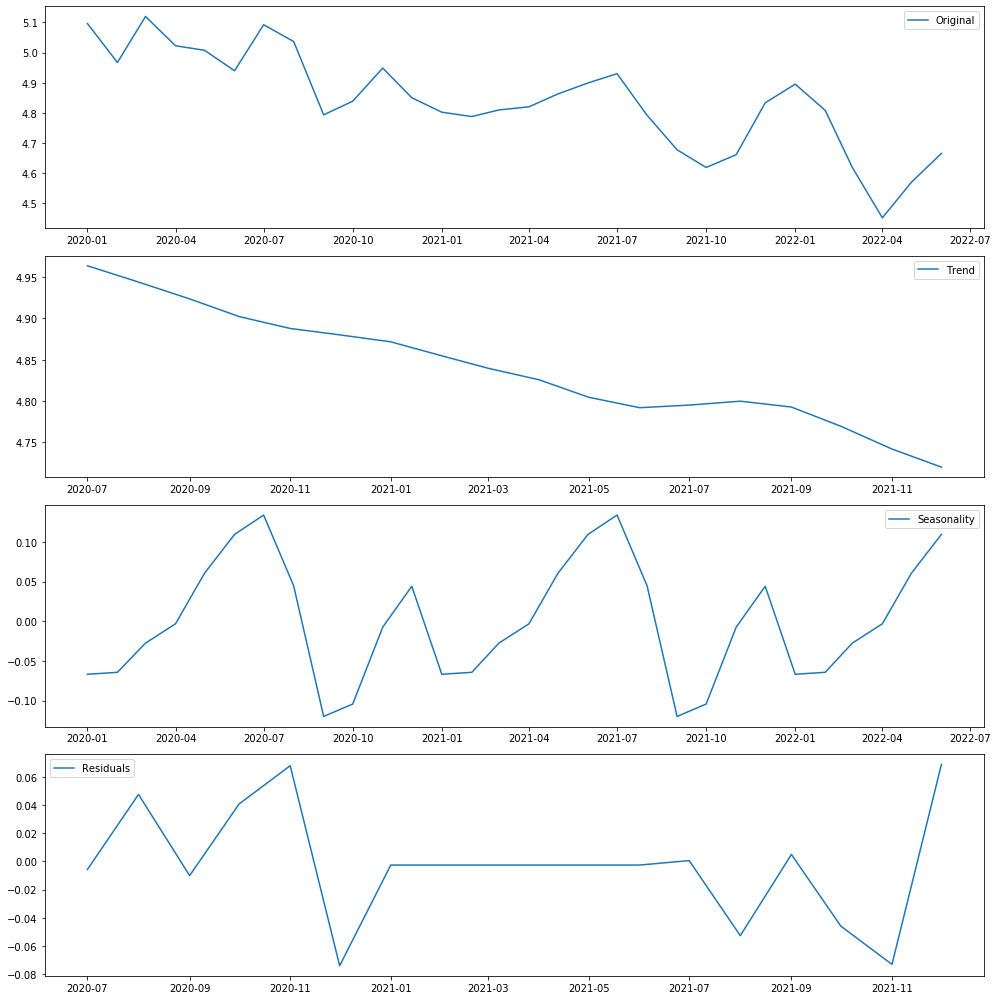

In [62]:
decompose(avgAdmissionTime_logScale)

### 4. Model building

Calculating ACF and PACF


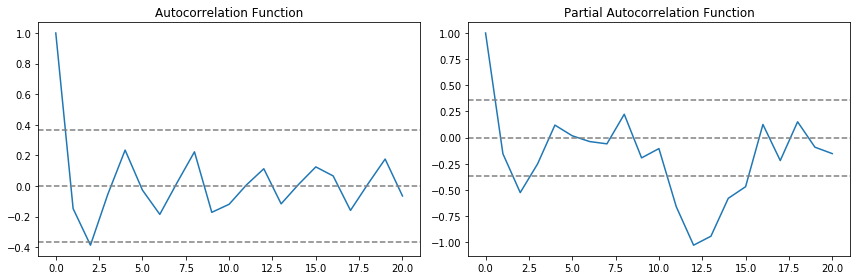

In [49]:
acf_pacf(avgAdmissionTimeLagdiffShifting,nlags=20)

Fitting the model for given data


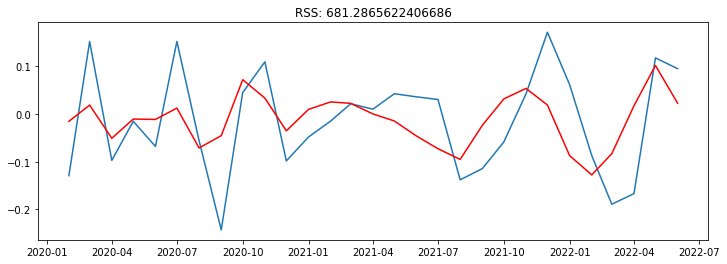

In [63]:
fit_model(avgAdmissionTime_logScale,avgAdmissionTimeLagdiffShifting,1,1,1)

### 5. Forecasting

Predicting and forecasting, values are in minutes


,0,1,2,3,4
0,100.319,96.9959,94.5832,92.4879,90.5033
1,11.1657,11.826,11.904,11.9135,11.9146
2,"[78.43430813716238, 122.20302559566595]","[73.81740476217425, 120.17440951220775]","[71.25181548941174, 117.91450606423365]","[69.13791341919995, 115.83784048816491]","[67.15108311376615, 113.8555998109773]"


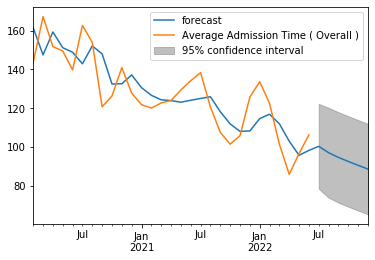

In [66]:
predict(avgAdmissionTime_logScale,5,1,1,1)